# Longstaff Schwartz Part 2: Comparison of Linear Regression & Neural Networks


`Objective`: Compare LS with linear regression and LS when using a neural network (non-linear regression) to learn the continuation function.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm

We use the structure of the previous notebook


### Parameters : 

In [34]:
np.random.seed(42)  # For reproducibility of results

x0 = 100    # Initial price of the asset
r = 0.04    # Interest rate
sigma = 0.1 # Volatility
T = 1       # Maturity
K = 100     # Strike price
N = 1000    # Number of discretization steps
# The asset will be simulated every 0.01 time units and the option holder can exercise it every 0.1 time units

number_of_paths = 100000  # Number of simulations


### Generation of trajectories


We start by generating `number_of_paths` asset trajectories following the Black-Scholes dynamics.


Time :  [0.    0.001 0.002 ... 0.998 0.999 1.   ]


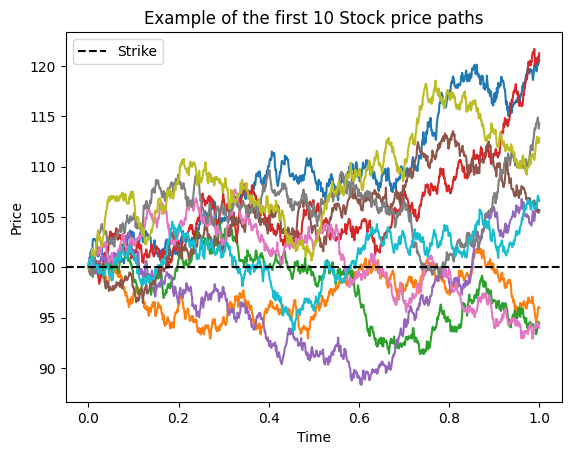

In [35]:
def generate_BS(x0, r, sigma, T, N, number_of_paths):
    dt = T/N
    time = np.linspace(0, T, N+1)

    dB = np.sqrt(dt) * np.random.randn(N, number_of_paths)
    brownian = np.zeros((N+1, number_of_paths))
    brownian[1:] = np.cumsum(dB, axis=0)

    t = time[:, np.newaxis]
    St = x0 * np.exp((r - 0.5*sigma**2)*t + sigma*brownian)

    return time, St.T

time, Xt = generate_BS(x0, r, sigma, T, N, number_of_paths)
for k in range(10):
    plt.plot(time, Xt[k])
print("Time : ", time)
plt.axhline(y=K, color='black', label='Strike', linestyle='--')
plt.title('Example of the first 10 Stock price paths')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### Below is the curve of the associated payoffs


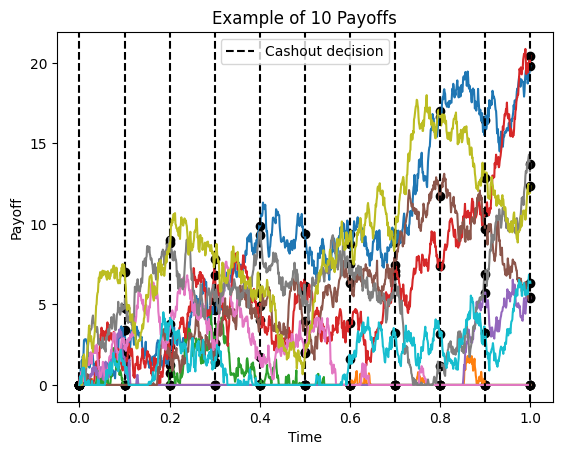

In [36]:
def payoff(x, t):  # t = 0, 100, ... 1000
    t = t / N  # then t = 0, 0.1, ... 1
    return np.maximum(x-K, 0) * np.exp(-r * t)

# Payoff over the entire duration
time_bis = (time * 1000).astype(int)
payoff_to_plot = np.zeros((number_of_paths, len(time_bis)))
for i, t in enumerate(time_bis):
    payoff_to_plot[:, i] = payoff(Xt[:, t], t)

# Payoff at different exercise times
execution_time = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
payoff_time = np.zeros((number_of_paths, len(execution_time)))
for i, t in enumerate(execution_time):
    payoff_time[:, i] = payoff(Xt[:, t], t)

for k in range(10):
    plt.plot(time, payoff_to_plot[k])
    plt.axvline(x=execution_time[k] / N, color='black', linestyle='--')
    plt.scatter(time[::100], payoff_time[k], color='black')
plt.axvline(x=execution_time[-1] / N, color='black', linestyle='--', label='Cashout decision')

plt.title('Example of 10 Payoffs')
plt.xlabel('Time')
plt.ylabel('Payoff')
plt.legend()
plt.show()


In [37]:
# Rows: payoff per trajectory
# Columns: payoff at each exercise time
payoff_time.shape


(100000, 11)

### We start by using a polynomial linear regressor:


We will test the polynomial basis: $\phi_i(x) = x^i$

$\Phi_k(x) = \sum_{i=0}^k \theta_i \phi_i(x) = \sum_{i=0}^k \theta_i x^i \approx \mathbb{E}(Payoff(X_{n+1}) | X_n = x)$, the continuation function.

In the following code, we will test up to $k=1,...,50$ (there will likely be overfitting if the degree is too high).


In [38]:
def longstaff_schwartz_1(X, time, r, T, N, K, k):
    tau = np.zeros((number_of_paths, len(execution_time))).astype(int)  # tau will contain the optimal stopping times for each trajectory
    tau[:, -1] = 10  # Initialization of the last tau to 10
    thetas = np.zeros((len(execution_time) - 1, k + 1))
    
    for i in range(len(execution_time) - 2, -1, -1):
        index_to_sum = tau[:, i + 1]
        payoffs = payoff_time[np.arange(number_of_paths), tau[:, i + 1]]
        Xs = Xt[:, execution_time[i]]  # Retrieve the values of X at time i
        theta_min = np.polyfit(Xs, payoffs, k)  # Polynomial regression
        thetas[i] = theta_min
        tau[:, i] = np.where(payoff_time[:, i] >= np.polyval(theta_min, Xs), i, tau[:, i + 1])
        
        '''if i == 9:
            plt.scatter(Xs, payoffs, color='red', label='Payoff')
            plt.scatter(Xs, np.polyval(theta_min, Xs), color='blue', label='Regression')
            plt.show()
        '''
    return tau, thetas

import warnings
warnings.filterwarnings("ignore")
taus_list = []
thetas_list = []
for k in range(1, 51):
    tau, thetas = longstaff_schwartz_1(Xt, time, r, T, N, K, k)
    
    taus_list.append(tau)
    thetas_list.append(thetas)
    print(k if k % 10 == 0 else "-", end=" ")
    # print(tau)
    # print(tau.shape)


- - - - - - - - - 10 - - - - - - - - - 20 - - - - - - - - - 30 - - - - - - - - - 40 - - - - - - - - - 50 

Let's plot some polynomial regressions for the first step of the LS algorithm:


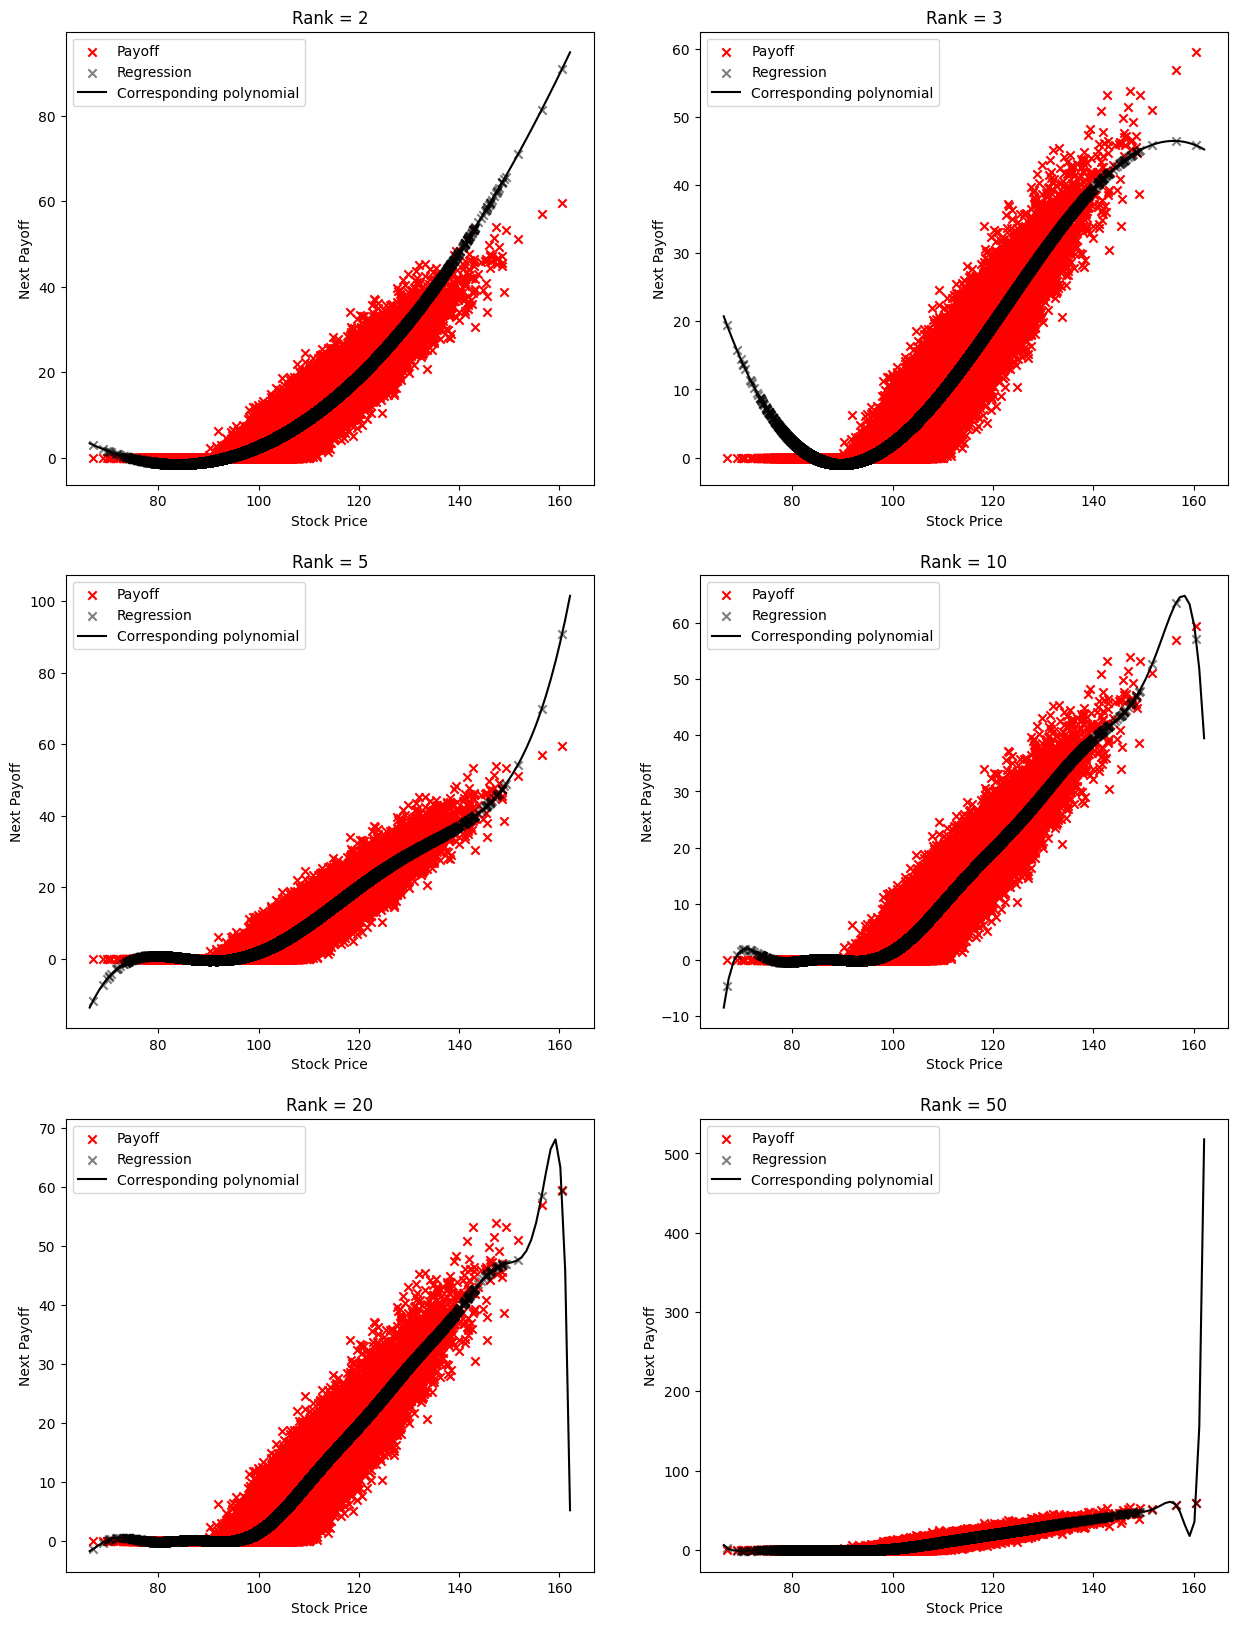

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
i = 9
ranks = [2,3,5,10,20,50]

for i,rank in enumerate(ranks):
    l=9
    axes[i//2,i%2].scatter(Xt[:, execution_time[l]], payoff_time[:, l+1], color='red', label='Payoff', marker='x')
    axes[i//2,i%2].scatter(Xt[:, execution_time[l]], np.polyval(thetas_list[rank-1][l], Xt[:, execution_time[l]]), color='black', label='Regression', marker='x', alpha=0.5)
    axes[i//2,i%2].plot(np.linspace(0.99*min(Xt[:, execution_time[l]]), max(1.01*Xt[:, execution_time[l]]), 100),
                np.polyval(thetas_list[rank-1][l], np.linspace(0.99*min(Xt[:, execution_time[l]]), max(1.01*Xt[:, execution_time[l]]), 100))
                , color='black', label='Corresponding polynomial')
    axes[i//2,i%2].set_title('Rank = '+str(rank))
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_xlabel('Stock Price')
    axes[i//2,i%2].set_ylabel('Next Payoff')

The higher the degree of the regressor polynomial, the more it overfits the dataset of trajectories. In the "extreme" case where the polynomial degree is 50, the regressor fits extremely well on our trajectories but explodes outside.

The pricing of the call will thus gain precision with the order of the regressor polynomial. However, if we change the trajectories and, unfortunately, one of the trajectories goes slightly outside the values where the polynomial fits perfectly, the errors will be enormous.

We will highlight the overfitting problem at the end of the assignment. For now, let's set that aside.

- Let's plot the price of the call as a function of the order of the regressor polynomial.


In [40]:
tau

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]])

In [41]:
def stopping_times(tau):
    stopping_times = np.zeros(number_of_paths)
    for i in range(number_of_paths):
        for j in range(len(execution_time)):
            if tau[i, j] == j:  # If tau[i,j] == j, then we have found the optimal stopping time for trajectory i
                stopping_times[i] = j
                break  # We exit to save computation time
    return stopping_times

st_times_list = [stopping_times(tau) for tau in taus_list]
print(st_times_list[1])


[ 8. 10. 10. ...  9. 10. 10.]


In [42]:
best_payoff_list = []
for st_times in st_times_list:
    best_payoff = np.zeros(number_of_paths)
    for i in range(number_of_paths):
        best_payoff[i] = payoff_time[i, int(st_times[i])]
    best_payoff_list.append(best_payoff)

As we increase the dimension of the regression basis, the price of the call seems to converge towards:  6.149


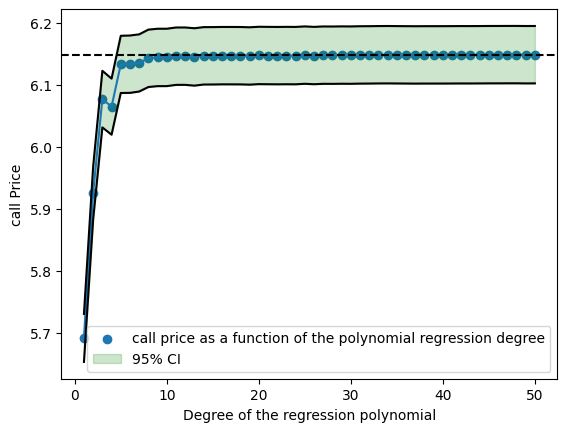

In [43]:
means = [np.mean(best_payoff) for best_payoff in best_payoff_list]
ic_size = [1.96 * np.sqrt(np.var(best_payoff, ddof=1) / number_of_paths) for best_payoff in best_payoff_list]
IC_up = [mean + ic for mean, ic in zip(means, ic_size)]
IC_down = [mean - ic for mean, ic in zip(means, ic_size)]
           
price_lr = np.mean(best_payoff_list[-10:]).round(3)
ic_size_lr = 1.96 * np.sqrt(np.var(best_payoff_list[-10:], ddof=1) / number_of_paths).round(3)

print("As we increase the dimension of the regression basis, the price of the call seems to converge towards: ", price_lr)
plt.scatter(range(1, 51), means, label='call price as a function of the polynomial regression degree')
plt.plot(range(1, 51), means)
plt.fill_between(range(1, 51), IC_down, IC_up, alpha=0.2, label='95% CI', color='green')
plt.plot(range(1, 51), IC_up, color='black')
plt.plot(range(1, 51), IC_down, color='black')
plt.xlabel('Degree of the regression polynomial')
plt.ylabel('call Price')
plt.axhline(y=np.mean(best_payoff_list[-10:]), color='black', linestyle='--', label='')
plt.legend()
plt.show()


- Apparently, we observe the following trend: the higher the degree of the polynomial, the higher the price of the call.


# LS with a Neural Network for regression:


We will use the Torch library in Python to define the architecture of our neural network and to train it.


In [44]:
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Torch requires converting all NumPy arrays into Torch tensors.


In [45]:
Xt_tensor = torch.tensor(Xt, dtype=torch.float64)
Xt_tensor

tensor([[100.0000, 100.1607, 100.4912,  ..., 120.1635, 120.4258, 120.6228],
        [100.0000,  99.9598,  99.5987,  ...,  95.9972,  96.0801,  95.9796],
        [100.0000, 100.2085, 100.3946,  ...,  94.5115,  94.3889,  94.4436],
        ...,
        [100.0000, 100.1330, 100.1872,  ..., 117.0229, 117.3247, 117.3220],
        [100.0000,  99.9368, 100.2111,  ..., 108.9921, 109.0936, 109.0354],
        [100.0000, 100.0415,  99.7086,  ..., 100.6731, 101.0809, 100.5307]],
       dtype=torch.float64)

Let's declare our neural network (NN).

Since the function to learn resembles $x \rightarrow (x-K)_+$, the network doesn't need to be very complicated/deep to "learn" the function.

Several architectures have been tested (2 to 3 layers with hidden layers of size 16, 32, 128). The code below implements a NN with 2 layers and a hidden size of 32.

We can certainly test other parameters, but these work well.


- Declaration of the NN:


In [46]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedForwardNet, self).__init__()
        hidden_size = 32
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.relu(x)
        return x
    
criterion = nn.MSELoss()

- Neural Network training function:

In [47]:
ep = []
train_list = []

def train_model(model_constructor, X, y, epochs, lr):
    input_size = X.shape[1]  
    output_size = 1 
    model = model_constructor(input_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        ep.append(epoch)
        train_list.append(loss.item())

        if epoch % 50 == 0 or epoch == epochs-1:
            print(f'Epoch {epoch}/{epochs}')
            print(f'Loss: {loss.item()}', end='\n\n')

    return model


- Then Longstaff Schwartz:

- At each backward iteration, we train our NN on the trajectories at the appropriate times. The NN becomes our approximation of the continuation function just like the linear regression at the beginning of the assignment.


- To normalize the data, we use the StandardScaler from Sklearn, which subtracts the mean and divides by the standard deviation of the data column.


In [48]:

def longstaff_schwartz_NN(X, time, r, T, N, K, nb_epochs, lr):

    tau = np.zeros((number_of_paths, len(execution_time))).astype(int)
    tau[:,-1] = 10
    model_list = []
    for i in range(len(execution_time)-2, -1, -1):
    

        print('backward step', i)
        index_to_sum = tau[:,i+1]
        payoffs = payoff_time[np.arange(number_of_paths), tau[:,i+1]]
        Xs = X[:, execution_time[i]]

        #Scaling pour le train
        X_scaler = StandardScaler()
        Y_scaler = StandardScaler()

        Xs_scale = X_scaler.fit_transform(Xs.reshape(-1, 1))
        Y_scale = Y_scaler.fit_transform(payoffs.reshape(-1, 1))

        Xs_scale = torch.tensor(Xs_scale, dtype=torch.float32)
        Y_scale = torch.tensor(Y_scale, dtype=torch.float32)
        
        model = train_model(FeedForwardNet, Xs_scale, Y_scale, epochs=nb_epochs, lr=lr)
        model_list.append(model)

        Ys_tensor_scaled = model(Xs_scale)
        Ys_unscaled = Y_scaler.inverse_transform(Ys_tensor_scaled.detach().numpy())
        Ys = Ys_unscaled.flatten()
    

        if i == 9:
            x_general = np.linspace(0.99*min(Xs), max(1.01*Xs), 100)
            x_general_scaled = X_scaler.transform(x_general.reshape(-1, 1))
            x_general_scaled = torch.tensor(x_general_scaled, dtype=torch.float32)
            y_general_scaled = model(x_general_scaled)
            y_general_unscaled = Y_scaler.inverse_transform(y_general_scaled.detach().numpy())
            y_general_unscaled = y_general_unscaled.flatten()
            to_display = [Xs, payoffs, Ys, x_general, y_general_unscaled]
            
        tau[:,i] = np.where(payoff_time[:,i] >= Ys, i, tau[:,i+1])
    return tau, model_list, to_display


After testing the algorithm by changing the parameters for the number of epochs and the learning rate, we retain the following parameters:


In [49]:
nb_epochs = 100
lr = 0.1
tau_NN, model_NN, to_display = longstaff_schwartz_NN(Xt_tensor, time, r, T, N, K, nb_epochs=nb_epochs, lr=lr)

backward step 9
Epoch 0/100
Loss: 1.5002784729003906

Epoch 50/100
Loss: 0.121239572763443

Epoch 99/100
Loss: 0.12050842493772507

backward step 8
Epoch 0/100
Loss: 1.1974185705184937

Epoch 50/100
Loss: 0.23344501852989197

Epoch 99/100
Loss: 0.23309625685214996

backward step 7
Epoch 0/100
Loss: 1.1979471445083618

Epoch 50/100
Loss: 0.3427644968032837

Epoch 99/100
Loss: 0.3421283960342407

backward step 6
Epoch 0/100
Loss: 0.7452483773231506

Epoch 50/100
Loss: 0.4464136064052582

Epoch 99/100
Loss: 0.44549721479415894

backward step 5
Epoch 0/100
Loss: 0.9882418513298035

Epoch 50/100
Loss: 0.5451305508613586

Epoch 99/100
Loss: 0.5448235273361206

backward step 4
Epoch 0/100
Loss: 0.9370692372322083

Epoch 50/100
Loss: 0.6447281837463379

Epoch 99/100
Loss: 0.6442866921424866

backward step 3
Epoch 0/100
Loss: 0.9561358690261841

Epoch 50/100
Loss: 0.7404120564460754

Epoch 99/100
Loss: 0.7401725053787231

backward step 2
Epoch 0/100
Loss: 1.3698674440383911

Epoch 50/100
Loss: 

A priori, the loss decreases significantly over the epochs, which is a good sign. Let's plot the loss for the 10 iterations of the LS algorithm and also plot the graph of the first regressor to visualize if our NN is learning the continuation function correctly:


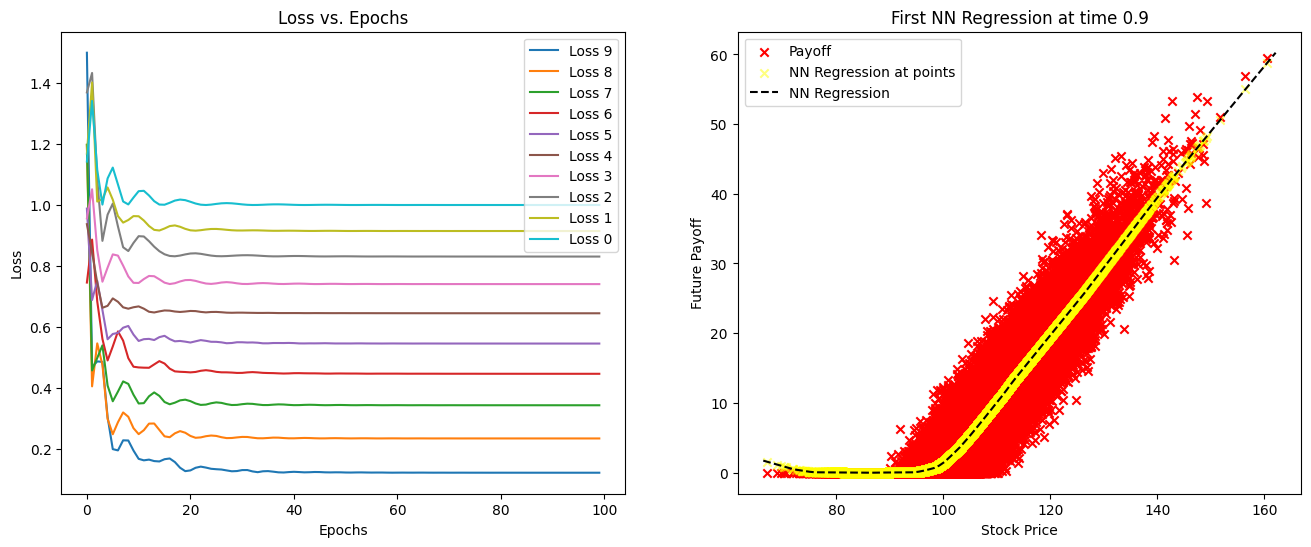

In [50]:
eps_split = []
train_list_split = []

for i in range(len(ep)):
    if (i) % nb_epochs == 0:
        eps_split.append(ep[i:i + nb_epochs])
        train_list_split.append(train_list[i:i + nb_epochs])
train_list_split = np.array(train_list_split)
eps_split = np.array(eps_split)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for k in range(10):
    axes[0].plot(eps_split[k], train_list_split[k], label='Loss ' + str(10 - k - 1))
axes[0].set_title('Loss vs. Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].scatter(to_display[0], to_display[1], color='red', label='Payoff', marker='x')
axes[1].scatter(to_display[0], to_display[2], color='yellow', label='NN Regression at points', marker='x', alpha=0.5)
axes[1].plot(to_display[3], to_display[4], color='black', label='NN Regression', linestyle='--')
axes[1].set_title('First NN Regression at time 0.9')
axes[1].set_xlabel('Stock Price')
axes[1].set_ylabel('Future Payoff')
axes[1].legend()

plt.show()


- We observe that the losses stagnate after a certain number of epochs, indicating that our NN has finished learning. This means that our NN will not be able to make better predictions with the current architecture.

- We also notice that as we move backward in the equation, the loss of the trained NN increases.

- However, as we can see in the graph on the right, the regression is significantly better than in the case of linear regression. (It is even better than the linear regression with the term $\theta_3(K-x)$ from the previous assignment.)


All that remains is to process the stopping times found and calculate the price of the call:


In [51]:
tau_NN

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]])

In [52]:
stopping_times_NN = stopping_times(tau_NN)
print(stopping_times_NN)

[10. 10. 10. ... 10. 10. 10.]


In [53]:
best_payoff_NN = np.zeros(number_of_paths)
for i in range(number_of_paths):
    best_payoff_NN[i] = payoff_time[i, int(stopping_times_NN[i])]
price_NN = np.mean(best_payoff_NN).round(3)
ic_size_NN = (1.96 * np.sqrt(np.var(best_payoff_NN, ddof=1) / number_of_paths))

In [54]:
print(f"With the neural network, the price of the call seems to be: ", price_NN, f" with a 95% confidence interval of [{price_NN - ic_size_NN:.4}, {price_NN + ic_size_NN:.4}]")
print(f"With the polynomial/linear regression, the price of the call seems to be: {price_lr} with a 95% confidence interval of [{price_lr - ic_size_lr:.4}, {price_lr + ic_size_lr:.4}]")


With the neural network, the price of the call seems to be:  6.146  with a 95% confidence interval of [6.1, 6.192]
With the polynomial/linear regression, the price of the call seems to be: 6.149 with a 95% confidence interval of [6.102, 6.196]


In [55]:
from scipy.stats import norm

def priceBS(x0, r, sigma, T, K):
    d1 = (np.log(x0/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return x0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
print('Black Scholes Price of European Call = ', priceBS(x0, r, sigma, T, K))

Black Scholes Price of European Call =  6.178461553404809


The two results are satisfactory as they are very close to each other. Moreover, the 95% confidence intervals obtained from Monte Carlo largely overlap.


----

----

# Brief additional research on overfitting in polynomial linear regression:

In this section, we will test the issues related to overfitting.


To do this, we will regenerate the asset trajectories with a different seed.


In [56]:
np.random.seed(43)
#random.seed(45)

time, Xt_check = generate_BS(x0, r, sigma, T, N, number_of_paths)

execution_time = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
payoff_time_check = np.zeros((number_of_paths, len(execution_time)))
for i, t in enumerate(execution_time):
    payoff_time_check[:, i] = payoff(Xt_check[:, t], t)

In [57]:
tau_list_check = []
for k in range(len(thetas_list)): 
    tau = np.zeros((number_of_paths, len(execution_time))).astype(int) #tau will contain the optimal stopping times for each trajectory
    tau[:, -1] = 10 #initialization of the last tau to 10
    for i in range(len(execution_time) - 2, -1, -1):
        index_to_sum = tau[:, i + 1]
        payoffs_check = payoff_time_check[np.arange(number_of_paths), tau[:, i + 1]]
        Xs_check = Xt_check[:, execution_time[i]] #retrieve the values of X at time i
        tau[:, i] = np.where(payoff_time_check[:, i] >= np.polyval(thetas_list[k][i], Xs_check), i, tau[:, i + 1])
    print(k if k % 10 == 0 else "-", end=" ")
    tau_list_check.append(tau)


0 - - - - - - - - - 10 - - - - - - - - - 20 - - - - - - - - - 30 - - - - - - - - - 40 - - - - - - - - - 

Plot the first regression with training and testing data:


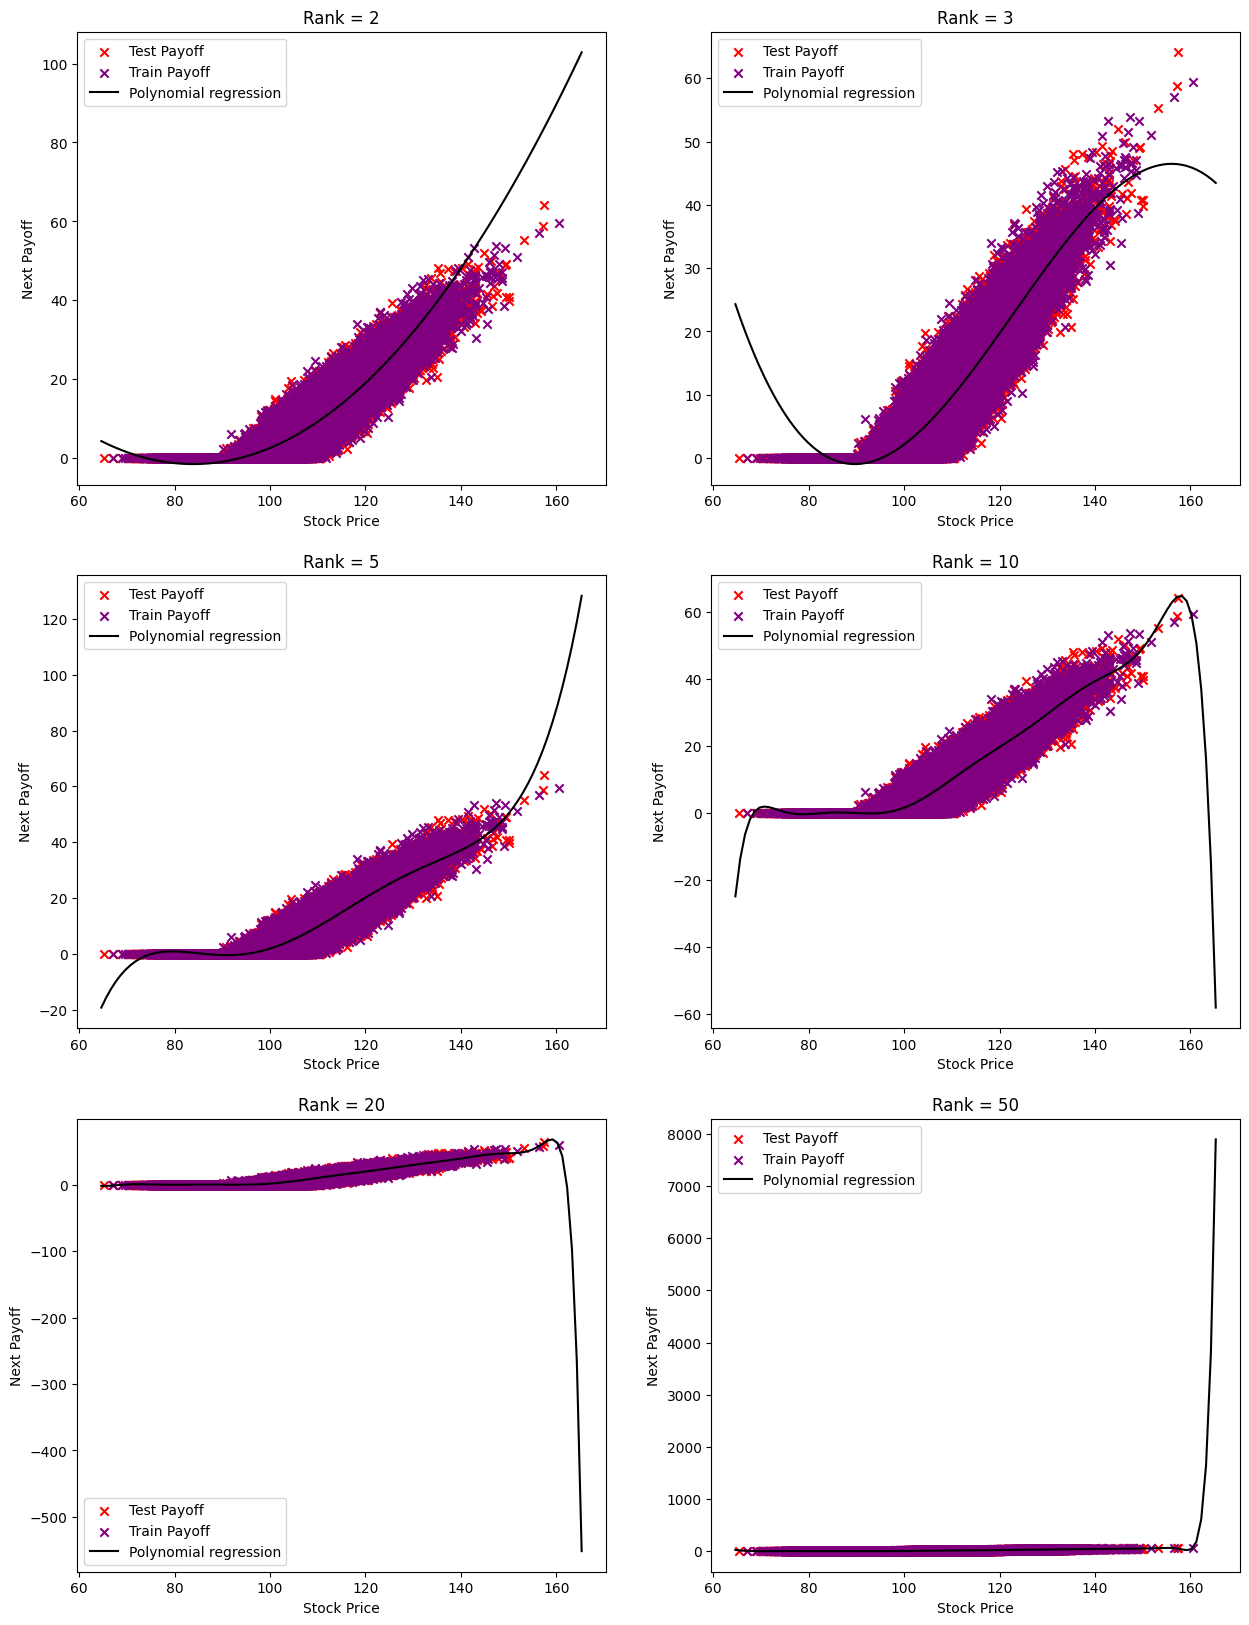

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
i = 9
ranks = [2, 3, 5, 10, 20, 50]

for i, rank in enumerate(ranks):
    
    l = 9
    axes[i // 2, i % 2].scatter(Xt_check[:, execution_time[l]], payoff_time_check[:, l + 1], color='red', label='Test Payoff', marker='x')
    axes[i // 2, i % 2].scatter(Xt[:, execution_time[l]], payoff_time[:, l + 1], color='purple', label='Train Payoff', marker='x')
    axes[i // 2, i % 2].plot(np.linspace(0.99 * min(Xt_check[:, execution_time[l]]), max(1.05 * Xt_check[:, execution_time[l]]), 100),
                np.polyval(thetas_list[rank - 1][l], np.linspace(0.99 * min(Xt_check[:, execution_time[l]]), max(1.05 * Xt_check[:, execution_time[l]]), 100)),
                color='black', label='Polynomial regression')
    axes[i // 2, i % 2].set_title('Rank = ' + str(rank))
    axes[i // 2, i % 2].legend()
    axes[i // 2, i % 2].set_xlabel('Stock Price')
    axes[i // 2, i % 2].set_ylabel('Next Payoff')


This is what can happen:

If we try to price another call option with new trajectories, and these trajectories move a bit outside the zone where the polynomial regressor fitted well the continuation function of the training trajectories, there can be large calculation errors. The higher the degree of the polynomial, the more it will fit the continuation function of the training trajectories. However, the further we move away from the fitting zone, the more outrageous the values predicted by the regressor can become. Thus, if we price another call with new trajectories, the calculated price may be incorrect.

Let's examine the difference in prices this can produce:

In [59]:
st_times_list_check = [stopping_times(tau) for tau in tau_list_check]
print(st_times_list_check[1])

[ 9. 10. 10. ...  9.  7. 10.]


In [60]:
best_payoff_list_check = []
for st_times in st_times_list_check:
    best_payoff = np.zeros(number_of_paths)
    for i in range(number_of_paths):
        best_payoff[i] = payoff_time_check[i, int(st_times[i])]
    best_payoff_list_check.append(best_payoff)

And here is the difference in prices this can produce:

Price on training set =  6.149
Price on test set / sanity check =  6.181


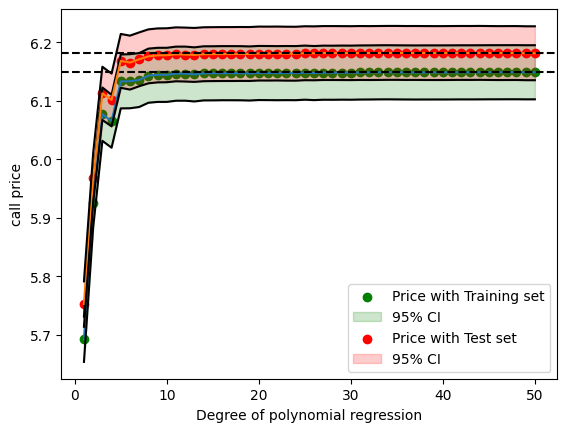

In [61]:
means_check = [np.mean(best_payoff) for best_payoff in best_payoff_list_check]
ic_size_check = [1.96 * np.sqrt(np.var(best_payoff, ddof=1) / number_of_paths) for best_payoff in best_payoff_list_check]
IC_up_check = [mean + ic for mean, ic in zip(means_check, ic_size_check)]
IC_down_check = [mean - ic for mean, ic in zip(means_check, ic_size_check)]

print("Price on training set = ", np.mean(best_payoff_list[-10:]).round(3))
print("Price on test set / sanity check = ", np.mean(best_payoff_list_check[-10:]).round(3))

plt.scatter(range(1,51), means, color='green', label='Price with Training set')
plt.plot(range(1,51), means)
plt.axhline(y=np.mean(best_payoff_list[-10:]), color='black', linestyle='--', label='')
plt.fill_between(range(1,51), IC_down, IC_up, alpha=0.2, label='95% CI', color='green')
plt.plot(range(1,51), IC_up, color='black')
plt.plot(range(1,51), IC_down, color='black')

plt.scatter(range(1,51), means_check, color='red', label='Price with Test set')
plt.plot(range(1,51), means_check)
plt.axhline(y=np.mean(best_payoff_list_check[-10:]), color='black', linestyle='--', label='')
plt.fill_between(range(1,51), IC_down_check, IC_up_check, alpha=0.2, label='95% CI', color='red')
plt.plot(range(1,51), IC_up_check, color='black')
plt.plot(range(1,51), IC_down_check, color='black')

plt.xlabel('Degree of polynomial regression')
plt.ylabel('call price')

plt.legend()
plt.show()


________